In [267]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
from typing import Tuple
from seaborn import heatmap
from tqdm import tqdm
from scipy.stats import norm

import importlib
import trading_dp
# Make changes to trading_dp.py file, then:
importlib.reload(trading_dp)
# Re-import specific functions/classes
from trading_dp import make_transition_matrix, get_theta_bounds, TradingDP

## Data preprocessing

In [3]:
# Read in Polymarket data from data folder
data_folder = Path('data')
all_dataframes = []

if os.path.exists("data/polymarket_combined.csv"):
    raise FileExistsError("polymarket_combined.csv already exists")

# Iterate through all market folders
for market_folder in tqdm(sorted(data_folder.glob('market=*')), desc='Processing markets'):
    # Extract market_id from folder name (remove 'market=' prefix)
    market_id = market_folder.name.replace('market=', '')
    
    # Iterate through all CSV files in the market folder
    for csv_file in sorted(market_folder.glob('*.csv')):
        # Extract timestamp from CSV filename (remove .csv extension)
        timestamp = csv_file.stem
        
        # Read the CSV file
        df = pd.read_csv(csv_file)
        
        # Add market_id and timestamp columns
        df['market_id'] = market_id
        df['timestamp'] = timestamp
        
        # Reorder columns to have market_id and timestamp first
        cols = ['market_id', 'timestamp'] + [col for col in df.columns if col not in ['market_id', 'timestamp']]
        df = df[cols]
        
        all_dataframes.append(df)

# Concatenate all dataframes
polymarket_data = pd.concat(all_dataframes, ignore_index=True)

output_file = 'data/polymarket_combined.csv'
polymarket_data.to_csv(output_file, index=False)
print(f"Combined data saved to {output_file}")
print(f"Total rows: {len(polymarket_data)}")
print(f"Total markets: {polymarket_data['market_id'].nunique()}")
print(f"Date range: {polymarket_data['timestamp'].min()} to {polymarket_data['timestamp'].max()}")


FileExistsError: polymarket_combined.csv already exists

In [270]:
polymarket_data = pd.read_csv("data/polymarket_combined.csv").sort_values(by=["market_id","timestamp"])
polymarket_data = polymarket_data[["market_id","timestamp","date","outcome","p_open"]]
polymarket_data["p_open"] = polymarket_data["p_open"].round(2)
# Split YES/NO contracts
polymarket_data_no = polymarket_data[polymarket_data["outcome"] == 0].copy()
polymarket_data_yes = polymarket_data[polymarket_data["outcome"] == 1].copy()

THRESHOLD = 0.9
FINAL_PRICE_THRESHOLD = 0.05

polymarket_df_no = []
for market_id, d in polymarket_data_no.groupby("market_id"):
    d = d.copy()
    
    # Find first occurrence of 0 or 1
    zero_idx = d[d["p_open"] == 0].index.min() if (d["p_open"] == 0).any() else None
    one_idx = d[d["p_open"] == 1].index.min() if (d["p_open"] == 1).any() else None
    
    # Get the earliest of 0 or 1
    truncate_idx = None
    if zero_idx is not None and one_idx is not None:
        truncate_idx = min(zero_idx, one_idx)
    elif zero_idx is not None:
        truncate_idx = zero_idx
    elif one_idx is not None:
        truncate_idx = one_idx
    
    # Truncate if found 0 or 1
    if truncate_idx is not None:
        d = d.loc[:truncate_idx]  # Include the 0/1 point
        # Check if still valid after truncation
        if len(d) > 0:
            # Apply your existing checks on truncated data
            pct_at_0 = (d["p_open"] == 0).sum() / len(d)
            pct_at_1 = (d["p_open"] == 1).sum() / len(d)
            if pct_at_0 >= THRESHOLD or pct_at_1 >= THRESHOLD:
                continue
            if d["p_open"].sum() < len(d):
                polymarket_df_no.append(d)
        continue
    
    # If no 0 or 1 found, apply original logic
    final_price = d["p_open"].iloc[-1]
    
    if not (0.05 <= final_price <= 0.95):
        if final_price >= 0.95:
            d.loc[d.index[-1], "p_open"] = 1.0
        elif final_price <= 0.05:
            d.loc[d.index[-1], "p_open"] = 0.0
        
        pct_at_0 = (d["p_open"] == 0).sum() / len(d)
        pct_at_1 = (d["p_open"] == 1).sum() / len(d)
        if pct_at_0 >= THRESHOLD or pct_at_1 >= THRESHOLD:
            continue
        
        if d["p_open"].sum() < len(d):
            polymarket_df_no.append(d)

polymarket_df_no = pd.concat(polymarket_df_no).sort_values(by=["market_id","timestamp"])
polymarket_df_no_ids = polymarket_df_no["market_id"].unique()

polymarket_df_yes = []
for market_id, d in polymarket_data_yes.groupby("market_id"):
    if market_id in polymarket_df_no_ids:
        continue
    
    d = d.copy()
    
    # Find first occurrence of 0 or 1
    zero_idx = d[d["p_open"] == 0].index.min() if (d["p_open"] == 0).any() else None
    one_idx = d[d["p_open"] == 1].index.min() if (d["p_open"] == 1).any() else None
    
    truncate_idx = None
    if zero_idx is not None and one_idx is not None:
        truncate_idx = min(zero_idx, one_idx)
    elif zero_idx is not None:
        truncate_idx = zero_idx
    elif one_idx is not None:
        truncate_idx = one_idx
    
    if truncate_idx is not None:
        d = d.loc[:truncate_idx]
        if len(d) > 0:
            pct_at_0 = (d["p_open"] == 0).sum() / len(d)
            pct_at_1 = (d["p_open"] == 1).sum() / len(d)
            if pct_at_0 >= THRESHOLD or pct_at_1 >= THRESHOLD:
                continue
            if d["p_open"].sum() < len(d):
                polymarket_df_yes.append(d)
        continue
    
    # Original logic
    final_price = d["p_open"].iloc[-1]
    
    if not (0.05 <= final_price <= 0.95):
        if final_price >= 0.95:
            d.loc[d.index[-1], "p_open"] = 1.0
        elif final_price <= 0.05:
            d.loc[d.index[-1], "p_open"] = 0.0
        
        pct_at_0 = (d["p_open"] == 0).sum() / len(d)
        pct_at_1 = (d["p_open"] == 1).sum() / len(d)
        if pct_at_0 >= THRESHOLD or pct_at_1 >= THRESHOLD:
            continue
        
        if d["p_open"].sum() < len(d):
            polymarket_df_yes.append(d)

polymarket_df_yes = pd.concat(polymarket_df_yes).sort_values(by=["market_id","timestamp"])

# Combine
polymarket_df = pd.concat([polymarket_df_no, polymarket_df_yes]).sort_values(by=["market_id","timestamp"])
polymarket_df

,market_id,timestamp,date,outcome,p_open
296,0x00a9dd3c3174468e2cee6ffa418dbf9b7e95c09788c2...,2025-07-20,2025-07-20,0,0.18
298,0x00a9dd3c3174468e2cee6ffa418dbf9b7e95c09788c2...,2025-07-21,2025-07-21,0,0.18
300,0x00a9dd3c3174468e2cee6ffa418dbf9b7e95c09788c2...,2025-07-22,2025-07-22,0,0.18
302,0x00a9dd3c3174468e2cee6ffa418dbf9b7e95c09788c2...,2025-07-23,2025-07-23,0,0.18
304,0x00a9dd3c3174468e2cee6ffa418dbf9b7e95c09788c2...,2025-07-24,2025-07-24,0,0.18
...,...,...,...,...,...
94832,0xffe237f9e05a1d42bebec1acfa447a3006d6af39bb60...,2025-08-16,2025-08-16,0,0.03
94834,0xffe237f9e05a1d42bebec1acfa447a3006d6af39bb60...,2025-08-17,2025-08-17,0,0.03
94836,0xffe237f9e05a1d42bebec1acfa447a3006d6af39bb60...,2025-08-18,2025-08-18,0,0.03
94838,0xffe237f9e05a1d42bebec1acfa447a3006d6af39bb60...,2025-08-19,2025-08-19,0,0.02


In [271]:
polymarket_paths = []
polymarket_ids = []
for i,d in polymarket_df.groupby("market_id"):
    d = d.sort_values(by="timestamp")
    flip = np.random.rand()
    if flip < .5:   # Outcome set to 0
        if d["p_open"].values[-1] == 1: # If original path is 1, flip to 0
            polymarket_paths.append(1-d["p_open"].values)
        else:
            polymarket_paths.append(d["p_open"].values)
    else:   # Outcome set to 1
        if d["p_open"].values[-1] == 1:
            polymarket_paths.append(d["p_open"].values)
        else:
            polymarket_paths.append(1-d["p_open"].values)   # If original path is 0, flip to 1
    polymarket_ids.append((i,int(flip+.5)))
    
polymarket_ids_df = pd.DataFrame(polymarket_ids, columns=["market_id","outcome"])
polymarket_ids_df

,market_id,outcome
0,0x00a9dd3c3174468e2cee6ffa418dbf9b7e95c09788c2...,0
1,0x00ad3bb5284b0b2314b1a2d42812fe292f606619c627...,0
2,0x00ca3a4205ea548274f06891fd4b703160675842dd01...,0
3,0x013823f6d4a068ff988ec880942bf9b3051db4034b5f...,0
4,0x0189df05ed7bf84d799213b01a79571e305c03b2ac53...,1
...,...,...
853,0xfee07be730188c94cd3644ed6f107fa3ea2dfab9989c...,0
854,0xfee4b6988b9513dab72118c97abeb4369f0d9a7c2290...,1
855,0xff8a022f8e283b5ddcee8aaf0b5cc4953cafee819991...,0
856,0xffd340f8363bae228ddcf3c97a527b7604ef588f2f27...,1


## Generate DP Policies

In [272]:
# B Tick Bounds
B_TICK_MIN=-.80
B_TICK_MAX=.80

# Price Bounds
C_MIN=.01
C_MAX=.99

# Get Min Max Theta
get_theta_bounds(C_MIN, C_MAX, B_TICK_MIN, B_TICK_MAX)

(-0.9974811083123425, 0.9974811083123425)

In [7]:
# Theta Bounds that cover min, max theta
THETA_MIN=-.999
THETA_MAX=.999

# Tick Counts
N_PRICES = 99
N_B_TICK = 100  
N_THETA = 3000

# Spread Parameters
GAMMA_YES_B = 0.05
GAMMA_YES_S = 0.10
GAMMA_NO_B = 0.05
GAMMA_NO_S = 0.10

# Max Time Horizon (longest price path)
T_MAX = polymarket_df.groupby("market_id").size().max()
print(f"T_MAX: {T_MAX}")

# Subjective Price Array
P_SUBJ_ARR = [0.1, 0.3, 0.5, 0.7, 0.9]
# Regime Array
REGIME_ARR = ["uniform", "rw", "mr"]

# DP Policy Dictionary
POLICY_DICT = {
    "uniform": {},
    "rw": {},
    "mr": {}
}

T_MAX: 32


In [273]:
# Initialize TradingDP
trading_dp = TradingDP(n_prices=N_PRICES, 
                       n_b_tick=N_B_TICK, 
                       n_theta=N_THETA, 
                       C_MIN=C_MIN, 
                       C_MAX=C_MAX,
                       B_TICK_MIN=B_TICK_MIN, 
                       B_TICK_MAX=B_TICK_MAX, 
                       THETA_MIN=THETA_MIN, 
                       THETA_MAX=THETA_MAX)

In [252]:
# Create Policy Matrices
for p_subj in tqdm(P_SUBJ_ARR):
    uniform_trans = make_transition_matrix(dist="uniform", n_prices=N_PRICES)
    rw_trans = make_transition_matrix(volatility = 1, mean_reversion = 0, n_prices=N_PRICES)
    mr_trans = make_transition_matrix(fair_value=p_subj, volatility = 1, mean_reversion = 0.5, n_prices=N_PRICES)
    
    regime_trans_arr = [uniform_trans, rw_trans, mr_trans]
    for i,regime_trans in enumerate(regime_trans_arr):
        V, policy = trading_dp.run_dp(regime_trans, 
                                      p_subj, 
                                      gamma_yes_b=GAMMA_YES_B,
                                      gamma_yes_s=GAMMA_YES_S,
                                      gamma_no_b=GAMMA_NO_B,
                                      gamma_no_s=GAMMA_NO_S,
                                      T=T_MAX)
        if p_subj not in POLICY_DICT[REGIME_ARR[i]]:
            POLICY_DICT[REGIME_ARR[i]][p_subj] = policy

100%|██████████| 5/5 [00:55<00:00, 11.16s/it]


## Backtest Results

In [338]:
results = trading_dp.simulate_trading(POLICY_DICT["rw"][0.7], 
                                      np.array([[.9,.3,.3,.3,.9,.99,1]]), 
                                      T_MAX = T_MAX,
                                      gamma_yes_b=GAMMA_YES_B,
                                      gamma_yes_s=GAMMA_YES_S,
                                      gamma_no_b=GAMMA_NO_B,
                                      gamma_no_s=GAMMA_NO_S,
                                      debug=True,
                                      n_jobs=-1)
results

Simulating paths: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

t: 25, theta: 0.0 c_curr: 0.9
t: 25, W_new: 87.4, x_new: 120.0, b: -0.12121212121212122, b_act: -0.12072434607645871

t: 26, theta: -0.49008168028004667 c_curr: 0.3
t: 26, W_new: 147.88, x_new: 24.0, b: -0.10505050505050506, b_act: -0.10201603109059992

t: 27, theta: -0.10201603109059992 c_curr: 0.3
t: 27, W_new: 162.37, x_new: 1.0, b: -0.008080808080808133, b_act: -0.004292635064696143

t: 28, theta: -0.004292635064696143 c_curr: 0.3
t: 28, W_new: 134.335, x_new: 91.0, b: 0.16969696969696968, b_act: 0.16889906270300367

t: 29, theta: 0.37875459569449904 c_curr: 0.9
t: 29, W_new: 178.33, x_new: 283.0, b: -0.13737373737373737, b_act: -0.13695978318733967

t: 30, theta: -0.015621550011039978 c_curr: 0.99
t: 30, W_new: 128.21349999999995, x_new: 5056.0, b: -0.2828282828282829, b_act: -0.2828159654534931

t: 31, W: 128.21349999999995, c_curr: 1.0, x: 0, theta: 0, b: 0


(array([0.24852666]), array([-0.29226374]), array([0]), array([0.24852666]))

In [301]:
polymarket_ids_df_copy = polymarket_ids_df.copy()
polymarket_ids_df_copy["elogW"] = results[0]
polymarket_ids_df_copy["max_pct_drawdown"] = results[1]
polymarket_ids_df_copy["pct_drawdown"] = results[2]
polymarket_ids_df_copy["elogW_m1"] = results[3]
polymarket_ids_df_copy["final_tradeW"] = polymarket_ids_df_copy["elogW"] - polymarket_ids_df_copy["elogW_m1"]
# polymarket_ids_df_copy["final_m1"] = [path[-2] for path in polymarket_paths]
polymarket_ids_df_copy["final"] = [path[-1] for path in polymarket_paths]
polymarket_ids_df_copy

,market_id,outcome,elogW,max_pct_drawdown,pct_drawdown,elogW_m1,final_tradeW,final
0,0x00a9dd3c3174468e2cee6ffa418dbf9b7e95c09788c2...,0,-2.122433,-0.800247,-0.880260,-2.122433,0.0,0.0
1,0x00ad3bb5284b0b2314b1a2d42812fe292f606619c627...,0,-1.648491,-0.799967,-0.807660,-1.648491,0.0,0.0
2,0x00ca3a4205ea548274f06891fd4b703160675842dd01...,0,-2.172786,-0.799634,-0.886140,-2.172786,0.0,0.0
3,0x013823f6d4a068ff988ec880942bf9b3051db4034b5f...,0,-2.893085,-0.800691,-0.944595,-2.893085,0.0,0.0
4,0x0189df05ed7bf84d799213b01a79571e305c03b2ac53...,1,-0.132806,-0.088863,-0.124365,-0.132806,0.0,1.0
...,...,...,...,...,...,...,...,...
853,0xfee07be730188c94cd3644ed6f107fa3ea2dfab9989c...,0,-1.648491,-0.799967,-0.807660,-1.648491,0.0,0.0
854,0xfee4b6988b9513dab72118c97abeb4369f0d9a7c2290...,1,0.294239,-0.170085,0.000000,0.294239,0.0,1.0
855,0xff8a022f8e283b5ddcee8aaf0b5cc4953cafee819991...,0,-1.177396,-0.799126,-0.691920,-1.177396,0.0,0.0
856,0xffd340f8363bae228ddcf3c97a527b7604ef588f2f27...,1,-0.119414,-0.072530,-0.112560,-0.119414,0.0,1.0


Text(0.5, 1.0, 'elogW')

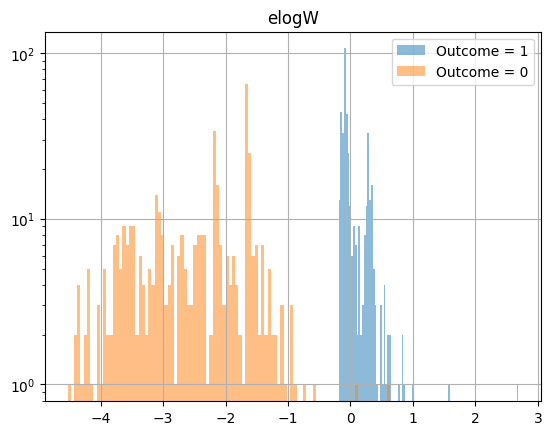

In [302]:
polymarket_ids_df_copy[polymarket_ids_df_copy["outcome"] == 1]["elogW"].hist(bins=100,alpha=.5,log=True,label="Outcome = 1")
polymarket_ids_df_copy[polymarket_ids_df_copy["outcome"] == 0]["elogW"].hist(bins=100,alpha=.5,log=True,label="Outcome = 0")
plt.legend()
plt.title("elogW")

Text(0.5, 1.0, 'max_pct_drawdown')

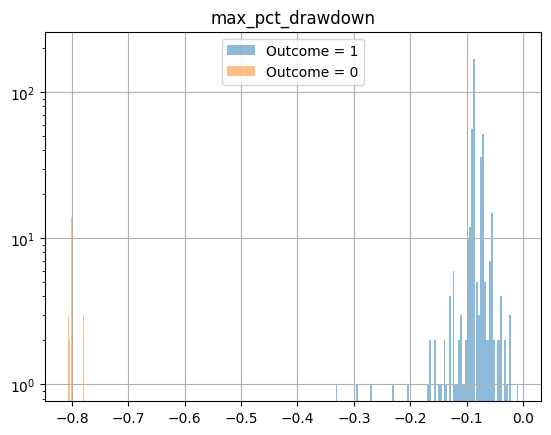

In [303]:
polymarket_ids_df_copy[polymarket_ids_df_copy["outcome"] == 1]["max_pct_drawdown"].hist(bins=100,alpha=.5,log=True,label="Outcome = 1")
polymarket_ids_df_copy[polymarket_ids_df_copy["outcome"] == 0]["max_pct_drawdown"].hist(bins=100,alpha=.5,log=True,label="Outcome = 0")
plt.legend()
plt.title("max_pct_drawdown")

Text(0.5, 1.0, 'pct_drawdown')

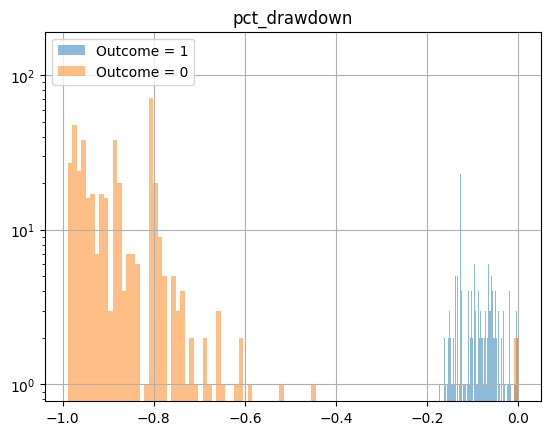

In [304]:
polymarket_ids_df_copy[polymarket_ids_df_copy["outcome"] == 1]["pct_drawdown"].hist(bins=100,alpha=.5,log=True,label="Outcome = 1")
polymarket_ids_df_copy[polymarket_ids_df_copy["outcome"] == 0]["pct_drawdown"].hist(bins=100,alpha=.5,log=True,label="Outcome = 0")
plt.legend()
plt.title("pct_drawdown")

Text(0.5, 1.0, 'elogW_m1')

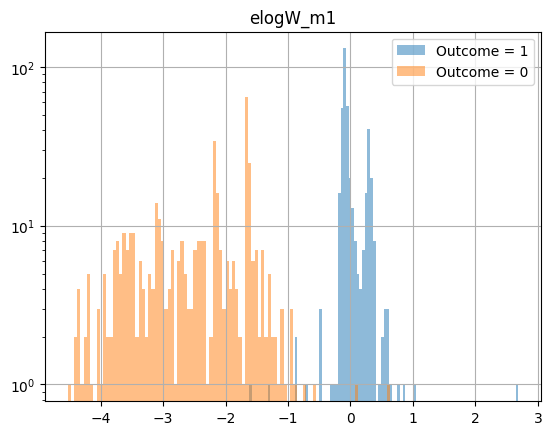

In [305]:
polymarket_ids_df_copy[polymarket_ids_df_copy["outcome"] == 1]["elogW_m1"].hist(bins=100,alpha=.5,log=True,label="Outcome = 1")
polymarket_ids_df_copy[polymarket_ids_df_copy["outcome"] == 0]["elogW_m1"].hist(bins=100,alpha=.5,log=True,label="Outcome = 0")
plt.legend()
plt.title("elogW_m1")

Text(0.5, 1.0, 'final_tradeW')

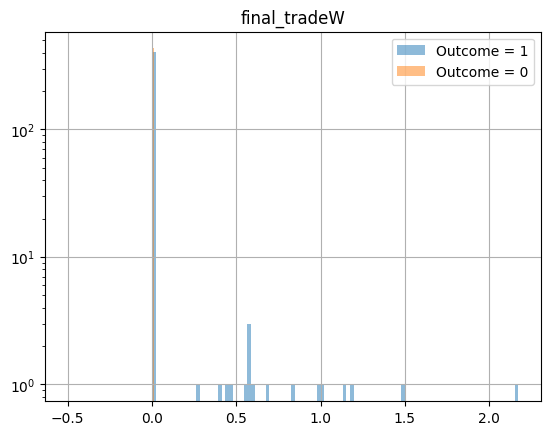

In [306]:
polymarket_ids_df_copy[polymarket_ids_df_copy["outcome"] == 1]["final_tradeW"].hist(bins=100,alpha=.5,log=True,label="Outcome = 1")
polymarket_ids_df_copy[polymarket_ids_df_copy["outcome"] == 0]["final_tradeW"].hist(bins=100,alpha=.5,log=True,label="Outcome = 0")
plt.legend()
plt.title("final_tradeW")

In [307]:
polymarket_ids_df_copy.groupby("outcome")["elogW"].describe()

,count,mean,std,min,25%,50%,75%,max
outcome,,,,,,,,
0,432.0,-2.450715,0.888770,-4.528672,-3.127557,-2.180987,-1.648491,0.634047
1,426.0,0.048599,0.257148,-0.190888,-0.097414,-0.065072,0.227500,2.689838
